In [93]:
# from mshr

from __future__ import print_function
from fenics import BoxMesh, Point, DirichletBC, FacetNormal, RectangleMesh
from fenics import FunctionSpace, VectorFunctionSpace
from fenics import TrialFunction, TestFunction
from fenics import Expression, Function, Constant
from fenics import dot, inner, Identity, sym
from fenics import grad, nabla_grad, tr
from ufl import nabla_div
from fenics import sqrt
from fenics import project
from fenics import dx, ds
from fenics import dX, dS
from fenics import solve, interpolate
from fenics import plot
from fenics import File
from fenics import lhs, rhs, assemble
from fenics import Mesh, UnitSquareMesh
from dolfin import near, SubDomain
from fenics import MeshFunction
# from dolfin import MeshFunction
from dolfin import info
# import dolfin


In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
line = './results/v0/'


In [96]:
save = 0


In [97]:
mu1 = Constant(0.8e11)
mu2 = Constant(0.5e11)
lambda1 = Constant(1.25e11)
lambda2 = Constant(0.65e11)
k1 = Constant(200.)
k2 = Constant(100.)
beta1 = Constant(6.0e-6)
beta2 = Constant(3.0e-6)
alphaAir = Constant(50.)
TAir = Constant(300.)
THot = Constant(450.)
T0 = Constant(320.)
eo = 1

In [98]:
# Material settings
rho = 7800  # [kg/m3] density
# k = 50  # [W/(m*K)] thermal conductivity
Cp = 525  # [J/(kg*K)] heat capacity
E = 2.0e011  # [Pa] Young modulus
nu = 0.3  # Poisson coefficient
lambda_ = (nu * E) / ((1 + nu) * (1 - 2 * nu))  # Lamé's first parameter
mu = E / (2 * (1 + nu))  # Lamé's second parameter
# alpha = 2.0e-05  # [1/K] thermal expansion coefficient

# Finite element order
eo = 1

#coefficient of slope
c1 = 10000
# coordinate "y", where is characteristics change
c2 = 0.002
# "stairs" function
phi_ = '1/(1+exp(-c1 * (x[1] - c2)))'
phi =  Expression(phi_,  c1 = c1, c2 = c2, degree=eo)

# 1 - bottom thin layer
# 2 - top layer

lambda1 = 1.25e11
lambda2 = 0.65e11
lambda_ = lambda2 * phi + lambda1 * (1-phi)

mu1 = 0.8e11
mu2 =0.5e11
mu = mu2 * phi + mu1 * (1-phi)

beta1 = 6.0e-06
beta2 =3.0e-06
alpha = beta2 * phi + beta1 * (1-phi)

k1 = 200  # [W/(m*K)] thermal conductivity on bottom layer
k2 = 100  # [W/(m*K)] thermal conductivity on top layer
k = k2 * phi + k1 * (1-phi)

# Domain settings
dW = 0.02  # [m] domain width (x, z)
dH = 0.012  # [m] domain height
dD = dW  # [m] domain depth
resW = 50  # mesh resolution (x, z)-directions (number of points)
resH = 50  # mesh y-resolution
resD = resW

print('Domain size:', dW, '[m] x', dH, '[m] y', dD, '[m] z')

# Finite element order
# eo = 1

Domain size: 0.02 [m] x 0.012 [m] y 0.02 [m] z


In [99]:
text = f"dw(х) = {dW}\n" \
       f"dh(у) = {dH}\n" \
       f"W (Сетка по х) = {resW}\n" \
       f"H (Сетка по у) = {resH}\n"
if save:
    print(text.encode('utf-8'),file=open(f"{line}par.txt",'w'))

In [100]:
mesh = Mesh('./mesh/CURRENT/composite_simplified.xml')
# mesh = Mesh('./mesh/composite.xml')
# mesh = UnitSquareMesh(32,32,dW,dH, 'left/right')
# mesh = RectangleMesh(Point(0.0, 0.0), Point(dW, dH), resW, resH,'left/right')
# mesh = RectangleMesh(Point(0.0, 0.0), Point(dW, dH), resW, resH,'left/right')


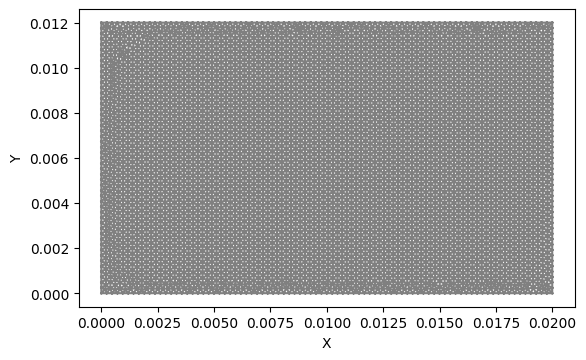

In [101]:
plot(mesh)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
if save:
    plt.savefig(f'{line}mesh_mshr.png')
    plt.savefig(f'{line}mesh_mshr.svg')

In [102]:
# Create functional space
F = FunctionSpace(mesh, 'CG', eo)  # piecewise linear polynomials
V = VectorFunctionSpace(mesh, 'CG', eo)

# Create 'trial function' (the unknown function to be approximated) over the space F
tem = TrialFunction(F)  # scalar temperature field, such that: tem(x,y) = Sum(tem_i* w(x,y))
d1 = tem.geometric_dimension()  # space dimension
u = TrialFunction(V)  # vector displacement field
d2 = u.geometric_dimension()  # space dimension


In [103]:
# Create scalar 'test function' (or 'shape function', or 'weighting function') over the space F
q = TestFunction(F)  # q -> tem
v = TestFunction(V)  # v -> u

t = 0
# Define expressions used in variational forms to prevent repeated code generation
n = FacetNormal(mesh)  # per-face normal vector
# k_ = (k / (rho * Cp))  # thermal conductivity
k_ = k  # thermal conductivity
Traction = Constant((0, 0))  # traction


In [104]:
# tem_surf = '(300 + ' \
#           '500 * exp(-pow( (t-5)/dt, 2)) * ' \
#          '( (( pow((x[0] - dW/2)/r, 2) + pow((x[2] - dD/2)/r, 2) ) <= 1.0) ? 1.0 : 0.0))'
tem_surf = '(THot * (x[1] == dH))'
# tem_surf = '(40)'
tem_desired = Expression(tem_surf, dH=dH, THot = THot, degree=eo)
# fact_ = Constant(1.0e8)

In [105]:

# Problem settings
tem_0 = T0  # [K] initial temperature
tem_ref = TAir  # [K] reference temperature


In [106]:
# Define strains and stress
def epsilon(u):
    return 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    # return sym(nabla_grad(u))


def epsilon_therm(tem):
    return alpha * (tem - tem_ref) * Identity(d1)


def sigma(u):
    return lambda_ * nabla_div(u) * Identity(d2) + 2 * mu * epsilon(u) \
        - (3 * lambda_ + 2 * mu) * epsilon_therm(tem)


# Compute boundary surfaces of the mesh (via C++ wrapper)

tol = 1E-14


# https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/subdomains-poisson/python/documentation.html
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)


class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], dH)


In [107]:

# bottom surfcae
# bs_bottom_wall = 'near(x[1], 0.0)'
# bs_bottom_wall = near(x[1],0.0)
bs_bottom_wall = Bottom()
# bs_top_wall = 'near(x[1],dH)'
# bs_top_wall = near(x[1],dH)
bs_top_wall = Top()

# bs_top_edges = [Point(0.0, dH), Point(dW, dH)]


# bs_top_edges = Point(0.0, dH)

def left_top_fixed_point(x, on_boundary):
    tol = 1E-15
    return (near(x[0], 0.0) and near(x[1],dH))

# def left_top_fixed_point(x, on_boundary):
#     tol = 1E-15
#     return Point(0.0, dH)


def right_top_fixed_point(x, on_boundary):
    tol = 1E-15
    return (near(x[0], dW) and near(x[1],dH))


In [108]:

# BC at the bottom
bc_tem_bottom = DirichletBC(F, Constant(300), bs_bottom_wall)
bc_tem_top = DirichletBC(F, THot, bs_top_wall)

#

# bcs_tem = [bc_tem_bottom]
bcs_tem = [bc_tem_bottom, bc_tem_top]
# bc_u_bottom = DirichletBC(V.sub(0), Constant((0,0)), bs_top_edges)
#
bc_top_fixed_point1 = DirichletBC(V.sub(0), Constant(0), right_top_fixed_point, method='pointwise')
bc_top_fixed_point2 = DirichletBC(V.sub(1), Constant(0), right_top_fixed_point, method='pointwise')

bc_lower_fixed_point1 = DirichletBC(V.sub(0), Constant(0), left_top_fixed_point, method='pointwise')
bc_lower_fixed_point2 = DirichletBC(V.sub(1), Constant(0), left_top_fixed_point, method='pointwise')
#
bcs_u = [bc_lower_fixed_point1,bc_lower_fixed_point2, bc_top_fixed_point1,bc_top_fixed_point2]
# bcs_u = [bc_u_bottom]

In [109]:
# Compose weak form of PDE(heat):
tem_0 = Expression('T0', degree=eo, T0 = T0)
tem_n = project(tem_0, F, solver_type="cg", preconditioner_type="amg")
tem = TrialFunction(F)
q = TestFunction(F)

In [110]:
fact_ = Constant(0.01)
# eq_tem = (k_ * inner(nabla_grad(tem), nabla_grad(q)) * dX + (tem_desired - tem) * fact_ * q * dX)
eq_tem = (k_ * inner(nabla_grad(tem), nabla_grad(q)) * dX + alphaAir * (tem - TAir) * q * dX)
a_therm = lhs(eq_tem)
L_therm = rhs(eq_tem)


In [111]:
# Compose weak form of PDE(elasticity):
# Split the equation into right-hand-side (RHS) and left-hand-side (LHS) parts:
u = TrialFunction(V)
v = TestFunction(V)
sigma_ = lambda_ * nabla_div(u) * Identity(d2) + mu * (nabla_grad(u) + nabla_grad(u).T) \
         - (3 * lambda_ + 2 * mu) * alpha * (tem_n - tem_ref) * Identity(d1)
epsilon_ = 0.5 * (nabla_grad(v) + nabla_grad(v).T)
elastic_eqn = inner(sigma_, epsilon_) * dX
# LHS, bilinear form
a_elas = lhs(elastic_eqn)
# RHS, Linear form
L_elas = rhs(elastic_eqn)


In [112]:
if save:
    # Prepare export to file
    path = line
    tem_file = File(f'{path}tem.pvd')
    u_file = File(f'{path}u.pvd')
    vms_file = File(f'{path}vms.pvd')

In [113]:
# Time loop
tem = Function(F)
u = Function(V)

print(f'DOFs = {V.dim() + F.dim()}')


DOFs = 15126


In [114]:
# Update time value in expression
# tem_desired.t = t

sol_settings = {'linear_solver': 'mumps'}

# Compute HCE
solve(a_therm == L_therm, tem, bcs_tem, solver_parameters=sol_settings)

# Update previous solution
tem_n.assign(tem)

# Compute elasticity
solve(a_elas == L_elas, u, bcs_u, solver_parameters=sol_settings)


Solving linear variational problem.
      Calling FFC just-in-time (JIT) compiler, this may take some time.
        Optimization not available for custom integrals, skipping optimization.
        Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.
        Ignoring precision in integral metadata compiled using quadrature representation. Not implemented.


/home/ponomdi/miniconda3/lib/python3.10/site-packages/ffc/quadrature/quadraturerepresentation.py:58: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()
/home/ponomdi/miniconda3/lib/python3.10/site-packages/ffc/quadrature/quadraturerepresentation.py:58: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Solving linear variational problem.


In [115]:
# Compute stress
s = sigma(u) - (1. / 3) * tr(sigma(u)) * Identity(d2)  # deviatoric stress
von_Mises = sqrt(3. / 2 * inner(s, s))
von_Mises = project(von_Mises, F)


In [116]:
if save:
    # Save solution
    tem.rename('T [K]', 'label')
    tem_file << (tem)
    u.rename('U [m]', 'label')
    u_file << (u)
    von_Mises.rename('VMS [Pa]', 'label')
    vms_file << (von_Mises)

print(f'{t}')
# print(f'{t} / {dt*num_steps}')


0


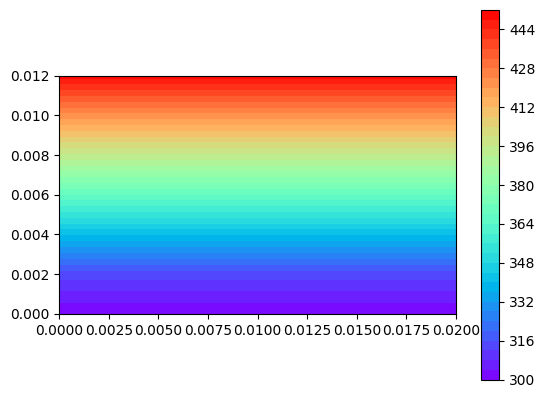

In [117]:
from matplotlib import cm
fig = plot(tem,mesh)
fig.set_cmap(cm.rainbow)
plt.colorbar(fig)
plt.show()

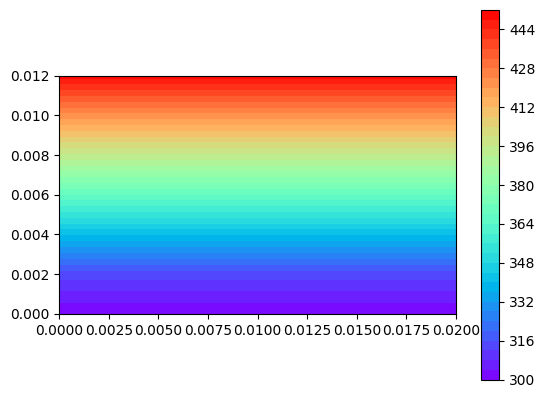

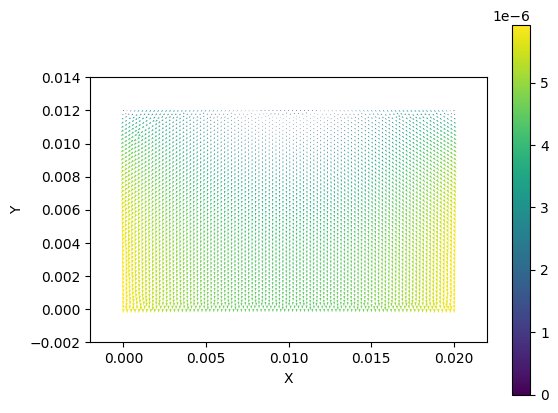

In [118]:
from matplotlib import cm
fig = plot(tem_n,mesh)
fig.set_cmap(cm.rainbow)

# gr = fig.axes.pcolor(tem.vector())
plt.colorbar(fig)
plt.show()
fig = plot(u,mesh)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-.002,0.022)
plt.ylim(-0.002,0.014)
plt.colorbar(fig)
if save:
    plt.savefig(f'{line}u_vec.png')
plt.show()